<a href="https://colab.research.google.com/github/Ridwanr989/google-maps-reviews-scraper/blob/main/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# menginstal library
!pip install transformers scikit-learn  # library dari Hugging Face untuk Natural Language Processing (NLP) dan Machine learning
!pip install gdown

In [ ]:
import pandas as pd
import gdown
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing dan Evaluasi
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Model Machine Learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluasi Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Transformer (NLP)
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from collections import Counter

In [ ]:
# Mengunduh file berada di gdrive
file_id = "1edaVdGAgHp85zkBXQXVs5DtI6SN9ogU8"
url = f"https://drive.google.com/uc?id={file_id}"
output = "ulasan4.csv"

gdown.download(url, output, quiet=False)

df = pd.read_csv("ulasan4.csv", encoding='latin1')

df

Downloading...
From: https://drive.google.com/uc?id=1edaVdGAgHp85zkBXQXVs5DtI6SN9ogU8
To: /content/ulasan4.csv
100%|██████████| 190k/190k [00:00<00:00, 52.1MB/s]


,nama,waktu,ulasan
0,kya chan,3 jam lalu,Rekomen pokonya sudah lebih dari 3x kesana gak...
1,Tendy Samsudin,8 jam lalu,NaN
2,samsi mustika,9 jam lalu,bersih & rapih udaranya msh sejuk
3,Reforms,10 jam lalu,NaN
4,Maman Jok vareasi,22 jam lalu,Tempat rekreasi yg sangat bagus buat semua kal...
...,...,...,...
2379,Double D Wheels & Garage,setahun lalu,NaN
2380,Dudi Gunawan,setahun lalu,Ikon nya bdg selatan..jangan lupa.. mampir dan...
2381,Attani Yakub,setahun lalu,NaN
2382,k hanifan,setahun lalu,Sangat indah


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

# Fungsi untuk mengkonversi waktu relatif menjadi bulan dan tahun
def konversi_ke_bulan_tahun(waktu_str):
    now = datetime.now()

    if pd.isna(waktu_str):
        return np.nan

    waktu_str = waktu_str.lower()

    if "detik" in waktu_str or "menit" in waktu_str or "jam" in waktu_str:
        tanggal = now
    elif "hari" in waktu_str:
        hari = int(waktu_str.split()[0])
        tanggal = now - timedelta(days=hari)
    elif "minggu" in waktu_str:
        minggu = int(waktu_str.split()[0]) if waktu_str.split()[0].isdigit() else 1
        tanggal = now - timedelta(weeks=minggu)
    elif "bulan" in waktu_str:
        bulan = int(waktu_str.split()[0]) if waktu_str.split()[0].isdigit() else 1
        bulan_lalu = now.month - bulan
        tahun = now.year
        if bulan_lalu <= 0:
            bulan_lalu += 12
            tahun -= 1
        tanggal = datetime(tahun, bulan_lalu, 1)
    elif "tahun" in waktu_str:
        tahun = now.year - 1
        tanggal = datetime(tahun, now.month, 1)
    else:
        return np.nan

    return tanggal.strftime('%B %Y')

# Terapkan fungsi ke kolom 'waktu'
df['bulan_tahun'] = df['waktu'].apply(konversi_ke_bulan_tahun)

# Tampilkan hasil contoh
print(df[['waktu', 'bulan_tahun']].head(5))

         waktu bulan_tahun
0   3 jam lalu    May 2025
1   8 jam lalu    May 2025
2   9 jam lalu    May 2025
3  10 jam lalu    May 2025
4  22 jam lalu    May 2025


In [ ]:
# Stopwords Bahasa Indonesia (bisa diperluas jika perlu)
stopwords_id = set(["yang", "dan", "di", "ke", "dari", "untuk", "dengan", "ada", "karena", "saja", "lebih",
                    "tidak", "bukan", "atau", "sudah", "masih", "seperti", "pada", "oleh", "itu", "ini", "sangat"])

# Fungsi untuk membersihkan teks
def clean_text(text):
    if not isinstance(text, str):
        return ""  # Jika bukan string, ubah menjadi string kosong
    text = text.lower()  # Ubah ke huruf kecil
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    text = text.strip()  # Hapus spasi di awal dan akhir
    text = ' '.join([word for word in text.split() if word not in stopwords_id])  # Hapus kata yang ada di stopwords_id
    return text

# Terapkan preprocessing ke kolom ulasan
df['clean_ulasan'] = df['ulasan'].astype(str).apply(clean_text)

In [ ]:
# Definisikan sektor dan kata kunci yang terkait
sektor_keywords = {
    "kebersihan": ["kotor", "bersih", "sampah", "jorok", "kebersihan"],
    "keamanan": ["aman", "keamanan", "penjaga", "satpam", "rawan", "copet"],
    "fasilitas": ["toilet", "parkir", "wifi", "kursi", "tempat sampah", "fasilitas"],
    "harga": ["mahal", "murah", "harga", "biaya", "bayar"],
    "pelayanan": ["ramah", "layanan", "petugas", "pegawai", "staff"],
    "akses": ["jalan", "akses", "macet", "transportasi", "angkutan", "rute"]
}

# Fungsi untuk menentukan sektor berdasarkan kata kunci
def assign_sector(text):
    for sektor, keywords in sektor_keywords.items():
        for keyword in keywords:
            if keyword in text:
                return sektor
    return "lainnya"

df['sektor'] = df['clean_ulasan'].apply(assign_sector)

In [ ]:
model_name = "w11wo/indonesian-roberta-base-sentiment-classifier" # model RoBERTa versi Bahasa Indonesia
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

# Fungsi Deteksi Sentimen
def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral"
    result = sentiment_pipeline(text)[0]['label']
    return result.lower()  # hasil akan jadi 'positive', 'negative', atau 'neutral'



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Dapatkan sentimen untuk setiap ulasan
df['sentimen'] = df['clean_ulasan'].apply(get_sentiment)

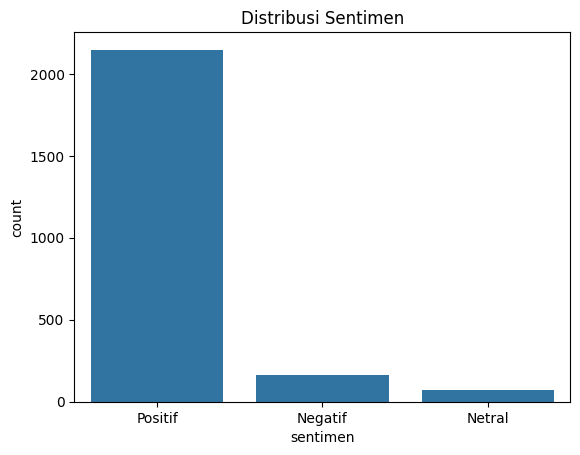

In [ ]:
# Pemetaan label sentimen ke angka
label_mapping = {"positive": 1, "neutral": 0, "negative": -1}
df['sentimen_label'] = df['sentimen'].map(label_mapping)

# Visualisasi Distribusi Sentimen
sns.countplot(x='sentimen', data=df)
plt.title("Distribusi Sentimen")
plt.show()

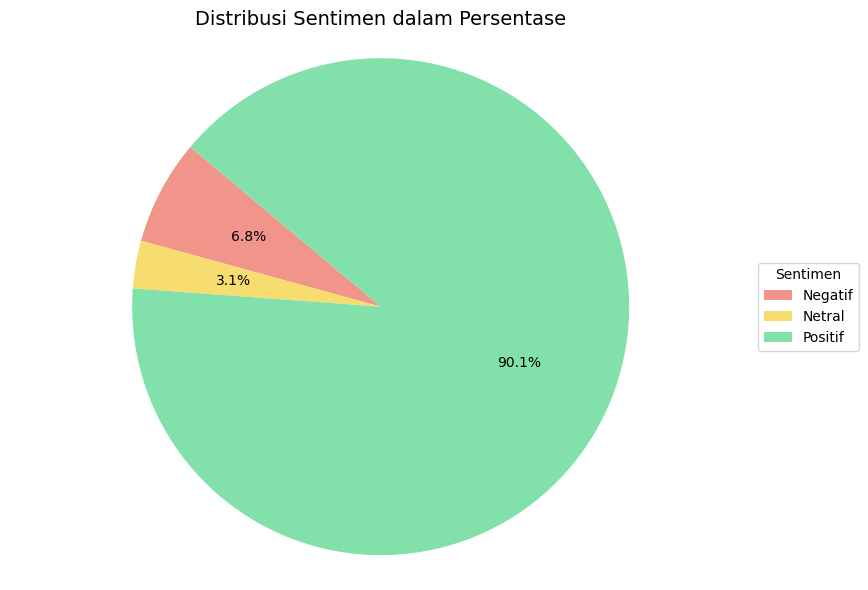

In [ ]:
# Hitung jumlah dan persentase sentimen
jumlah_sentimen = df['sentimen_label'].value_counts().sort_index()
persentase_sentimen = (jumlah_sentimen / jumlah_sentimen.sum()) * 100

# Siapkan label dan data
labels = ['Negatif', 'Netral', 'Positif']
sizes = [
    persentase_sentimen.get(-1, 0),
    persentase_sentimen.get(0, 0),
    persentase_sentimen.get(1, 0)
]

colors = ['#F1948A', '#F7DC6F', '#82E0AA']

# Plot pie chart
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    textprops=dict(color="black")
)

# Tambahkan legend di sebelah kanan
ax.legend(
    wedges,
    labels,
    title="Sentimen",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

# Judul dan layout
plt.title('Distribusi Sentimen dalam Persentase', fontsize=14)
plt.tight_layout()
plt.axis('equal')
plt.show()

In [ ]:
# Jumlah komentar negatif per sektor
tabel_ringkasan_negatif = df[df['sentimen_label'] == -1].groupby('sektor').size().reset_index(name='jumlah_komentar_negatif')
tabel_ringkasan_negatif = tabel_ringkasan_negatif.sort_values(by='jumlah_komentar_negatif', ascending=False)

print("Tabel Ringkasan Komentar Negatif Berdasarkan Sektor:")
display(tabel_ringkasan_negatif)


Tabel Ringkasan Komentar Negatif Berdasarkan Sektor:


,sektor,jumlah_komentar_negatif
5,lainnya,96
2,harga,30
1,fasilitas,14
0,akses,7
4,kebersihan,6
3,keamanan,5
6,pelayanan,5


In [ ]:
# Tabel komentar negatif berdasarkan sektor
tabel_negatif = df[df['sentimen_label'] == -1][['ulasan', 'sektor', 'sentimen_label']]
tabel_negatif_sorted = tabel_negatif.sort_values(by='sektor')

print("Tabel Komentar Negatif Berdasarkan Sektor:")
display(tabel_negatif_sorted.head(20))


Tabel Komentar Negatif Berdasarkan Sektor:


,ulasan,sektor,sentimen_label
2336,Libur national ga nahan macetnya,akses,-1
86,"Tempat nya bagus , tapi jalan ke arah lokasi n...",akses,-1
1817,"Hati hati sama yang nawarin jasa foto, ujung2 ...",akses,-1
1252,"Tiket kendaraan pribadi nya muaahaaal banget,g...",akses,-1
1884,Pertama kesini hari Kamis 20/06/24 malah kesor...,akses,-1
1333,Libur national ga nahan macetnya,akses,-1
2255,"Tiket kendaraan pribadi nya muaahaaal banget,g...",akses,-1
1628,kalo musim hujan hati hati bawa motor ya apa l...,fasilitas,-1
1119,"terlalu mahal,,sya bawa mobil cuma 2orang 28rb...",fasilitas,-1
2007,"Tukang parkirnya bad attitude, lebih beretika ...",fasilitas,-1


<ipython-input-11-d1cc58876bd7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=negatif_per_sektor.index, y=negatif_per_sektor.values, palette="Reds_r")


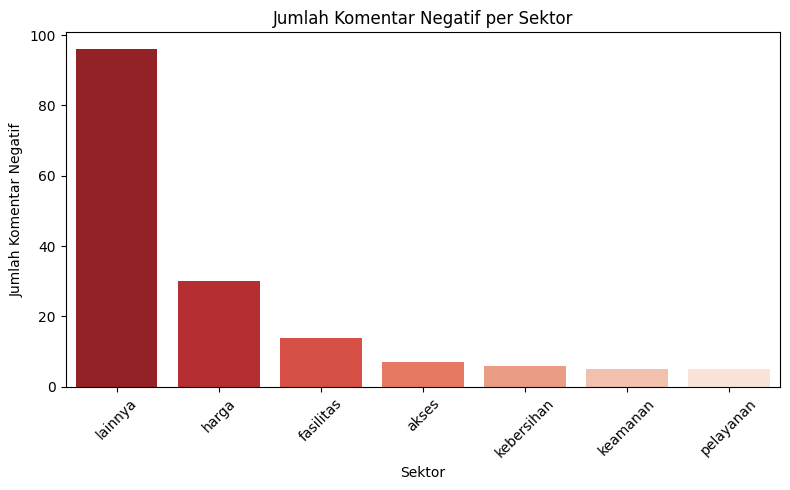

In [ ]:
# Hitung jumlah komentar negatif berdasarkan sektor
negatif_per_sektor = df[df['sentimen_label'] == -1]['sektor'].value_counts()

# Visualisasi
plt.figure(figsize=(8, 5))
sns.barplot(x=negatif_per_sektor.index, y=negatif_per_sektor.values, palette="Reds_r")
plt.title("Jumlah Komentar Negatif per Sektor")
plt.ylabel("Jumlah Komentar Negatif")
plt.xlabel("Sektor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


,bulan_tahun,jumlah_negatif
9,May 2025,13
0,April 2025,25
7,March 2025,25
3,February 2025,9
4,January 2025,7
2,December 2024,20
10,November 2024,8
11,October 2024,13
12,September 2024,8
1,August 2024,15


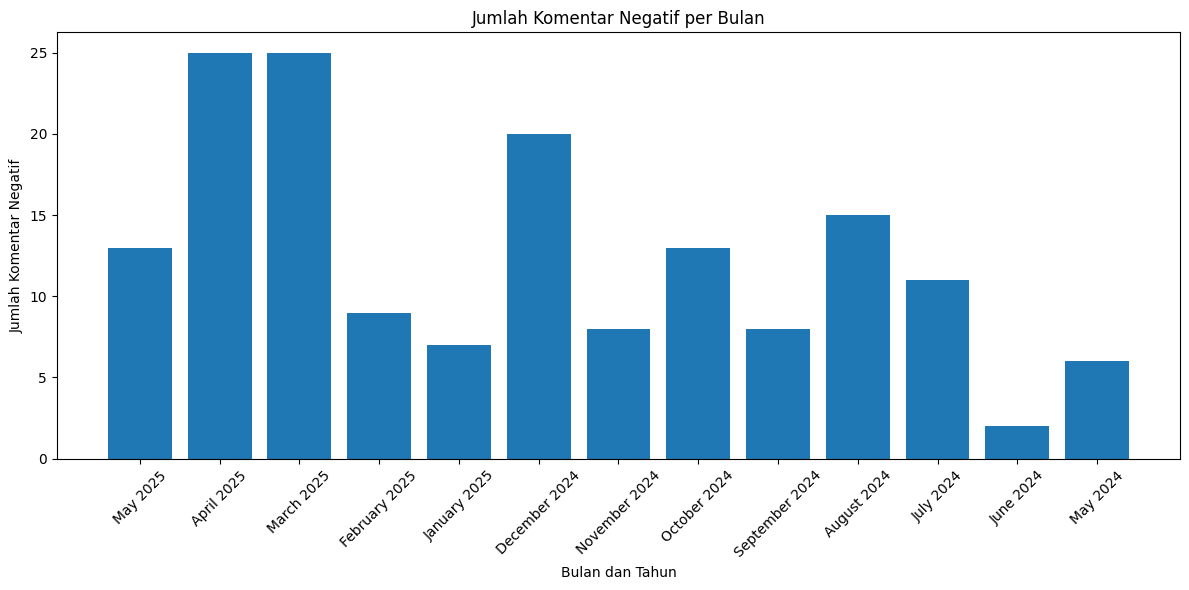

In [ ]:
# Filter hanya komentar negatif
df_negatif = df[df['sentimen_label'] == -1]
komentar_negatif_per_bulan = df_negatif.groupby('bulan_tahun').size().reset_index(name='jumlah_negatif')


# Ubah 'bulan_tahun' menjadi format datetime
komentar_negatif_per_bulan['bulan_tahun_dt'] = pd.to_datetime(komentar_negatif_per_bulan['bulan_tahun'], format='%B %Y')
komentar_negatif_per_bulan = komentar_negatif_per_bulan.sort_values(by='bulan_tahun_dt', ascending=False)
komentar_negatif_per_bulan['bulan_tahun'] = komentar_negatif_per_bulan['bulan_tahun_dt'].dt.strftime('%B %Y')
komentar_negatif_per_bulan = komentar_negatif_per_bulan[['bulan_tahun', 'jumlah_negatif']]

# print(komentar_negatif_per_bulan)
display(komentar_negatif_per_bulan)

# Plot grafik batang
plt.figure(figsize=(12, 6))
plt.bar(komentar_negatif_per_bulan['bulan_tahun'], komentar_negatif_per_bulan['jumlah_negatif'])

# Tambahkan label dan judul
plt.xlabel('Bulan dan Tahun')
plt.ylabel('Jumlah Komentar Negatif')
plt.title('Jumlah Komentar Negatif per Bulan')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Top 5 Sektor dengan Komentar Negatif Terbanyak per Bulan:


,bulan_tahun,sektor,jumlah_komentar_negatif
35,May 2025,lainnya,8
33,May 2025,harga,3
32,May 2025,akses,1
34,May 2025,keamanan,1
3,April 2025,lainnya,14
1,April 2025,harga,5
0,April 2025,fasilitas,4
2,April 2025,keamanan,1
4,April 2025,pelayanan,1
29,March 2025,lainnya,20


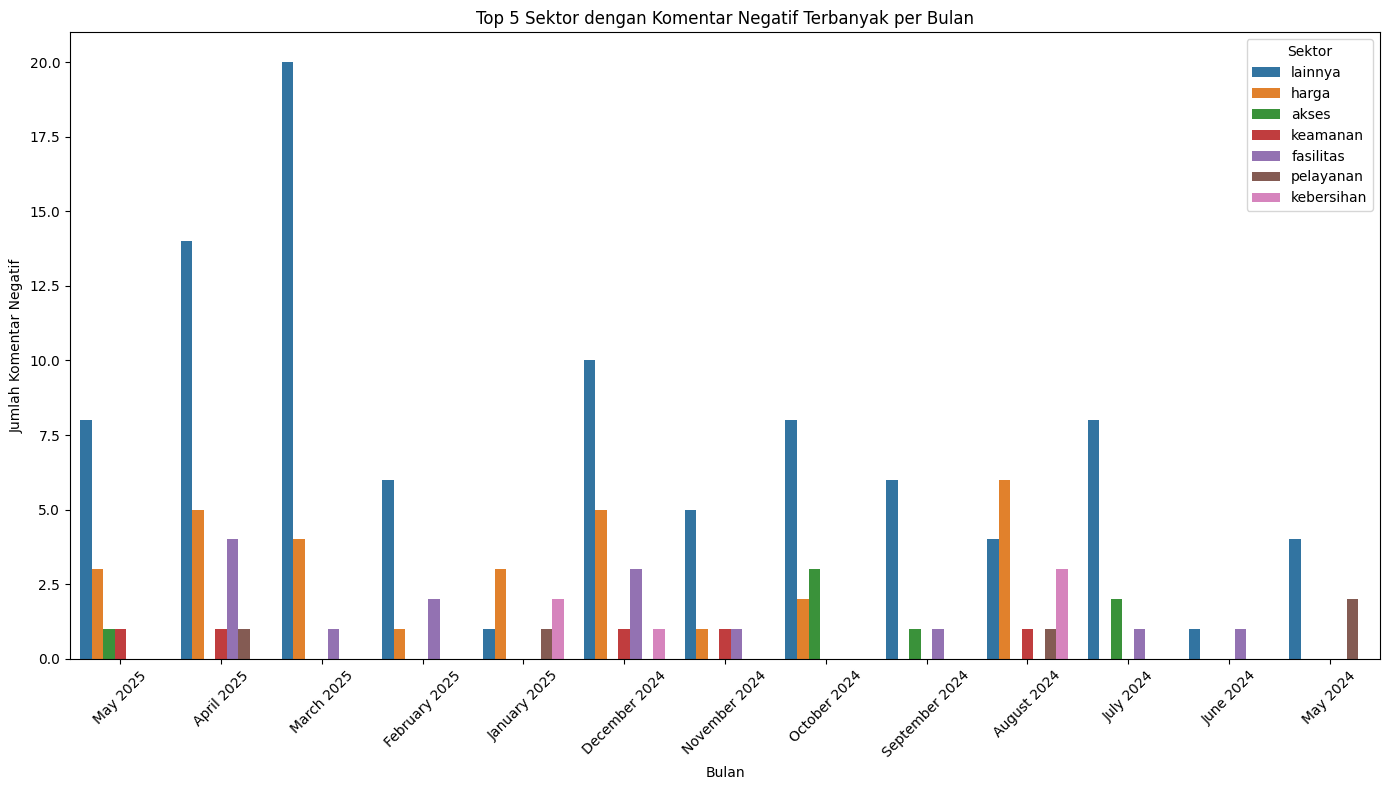

In [ ]:
# Filter hanya komentar negatif
df_negatif = df[df['sentimen_label'] == -1]

# Group by bulan_tahun dan sektor
negatif_per_bulan_sektor = df_negatif.groupby(['bulan_tahun', 'sektor']).size().reset_index(name='jumlah_komentar_negatif')

# Urutkan berdasarkan bulan (jika perlu diurutkan secara waktu)
negatif_per_bulan_sektor['bulan_tahun_dt'] = pd.to_datetime(negatif_per_bulan_sektor['bulan_tahun'], format='%B %Y')
negatif_per_bulan_sektor = negatif_per_bulan_sektor.sort_values(by=['bulan_tahun_dt', 'jumlah_komentar_negatif'], ascending=[False, False])

# Tampilkan 5 sektor terbanyak per bulan (opsional)
top5_per_bulan = negatif_per_bulan_sektor.groupby('bulan_tahun').head(5)

# Cetak hasil
print("Top 5 Sektor dengan Komentar Negatif Terbanyak per Bulan:")
display(top5_per_bulan[['bulan_tahun', 'sektor', 'jumlah_komentar_negatif']])

plt.figure(figsize=(14, 8))
sns.barplot(data=top5_per_bulan, x='bulan_tahun', y='jumlah_komentar_negatif', hue='sektor')
plt.title('Top 5 Sektor dengan Komentar Negatif Terbanyak per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Komentar Negatif')
plt.xticks(rotation=45)
plt.legend(title='Sektor')
plt.tight_layout()
plt.show()


In [ ]:
komentar_negatif = df[df['sentimen_label'] == -1]
komentar_negatif = komentar_negatif.copy()
komentar_negatif['bulan_tahun_dt'] = pd.to_datetime(komentar_negatif['bulan_tahun'], format='%B %Y')
komentar_negatif_per_bulan = komentar_negatif.groupby('bulan_tahun_dt').size().reset_index(name='jumlah')
komentar_terbanyak = komentar_negatif_per_bulan.sort_values(by='jumlah', ascending=False).iloc[0]

# Ambil bulan dengan komentar negatif terbanyak
target_bulan = komentar_terbanyak['bulan_tahun_dt']
komentar_bulan_ini = komentar_negatif[komentar_negatif['bulan_tahun_dt'] == target_bulan]

# Ambil 3 kata yang paling sering muncul di clean_ulasan
all_words = ' '.join(komentar_bulan_ini['clean_ulasan']).split()
common_words = Counter(all_words).most_common(3)

# Format saran
bulan_str = target_bulan.strftime('%B %Y')
kata_utama = ', '.join([f"'{kata}'" for kata, _ in common_words])
saran = f"📌 Pada bulan {bulan_str}, hal yang perlu diperhatikan adalah kata-kata yang sering muncul seperti {kata_utama}. Hal ini menunjukkan bahwa aspek-aspek tersebut perlu diperbaiki."

print(saran)

📌 Pada bulan April 2025, hal yang perlu diperhatikan adalah kata-kata yang sering muncul seperti 'tiket', 'k', 'banyak'. Hal ini menunjukkan bahwa aspek-aspek tersebut perlu diperbaiki.


In [ ]:
# Pastikan tidak ada nilai NaN di data sebelum split
df = df.dropna(subset=['clean_ulasan', 'sentimen_label'])

label_map = {
    1: 'Positif',
    0: 'Netral',
    -1: 'Negatif'
}

df['sentimen'] = df['sentimen_label'].map(label_map)
df[['clean_ulasan', 'sentimen_label', 'sentimen']].head(50)

,clean_ulasan,sentimen_label,sentimen
0,rekomen pokonya x kesana gak pernah kecew,1,Positif
1,nan,1,Positif
2,bersih rapih udaranya msh sejuk,1,Positif
3,nan,1,Positif
4,tempat rekreasi yg bagus buat semua kalangan c...,1,Positif
5,nan,1,Positif
6,nan,1,Positif
7,rapih bersih lumayan lengkap,1,Positif
8,musolah yg diluar kenapa sekarang,-1,Negatif
9,area luas bgt tempatnya enak nyaman lah tenant...,1,Positif


In [ ]:
# Pisahkan data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(df['clean_ulasan'],
    df['sentimen_label'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentimen_label'])

In [ ]:
# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# SMOTE untuk balancing data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_tfidf, y_train)

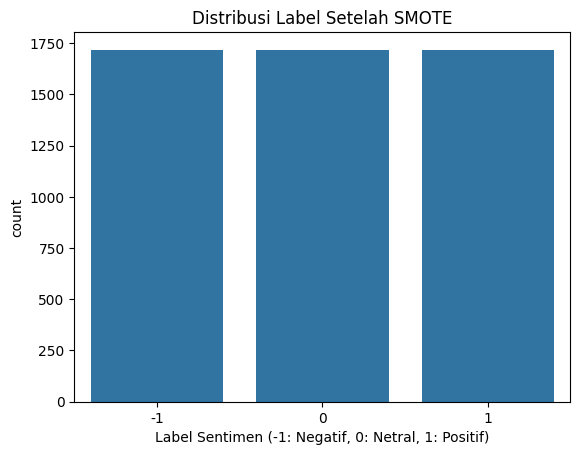

Distribusi label setelah SMOTE: Counter({-1: 1718, 1: 1718, 0: 1718})


In [ ]:
# Visualisasi Distribusi Label setelah SMOTE dan menampilkan Jumlah Tiap Label
sns.countplot(x=y_res)
plt.title("Distribusi Label Setelah SMOTE")
plt.xlabel("Label Sentimen (-1: Negatif, 0: Netral, 1: Positif)")
plt.show()
print("Distribusi label setelah SMOTE:", Counter(y_res))

In [ ]:
# melatih model Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_res, y_res)


MultinomialNB()

In [ ]:
# Prediksi pada data latih
predictions_nb = nb_model.predict(X_test_tfidf)

# Evaluasi performa model
accuracy_nb = accuracy_score(y_test, predictions_nb)
print(f'Akurasi Model Naïve Bayes: {accuracy_nb:.2f}')
print(classification_report(
    y_test,
    predictions_nb,
    labels=[-1, 0, 1],
    target_names=["Negatif", "Netral", "Positif"]
))
print(df['sentimen'].value_counts())
print(df['sentimen_label'].value_counts())


Akurasi Model Naïve Bayes: 0.83
              precision    recall  f1-score   support

     Negatif       0.30      0.76      0.43        33
      Netral       0.28      0.33      0.30        15
     Positif       0.98      0.85      0.91       429

    accuracy                           0.83       477
   macro avg       0.52      0.65      0.55       477
weighted avg       0.91      0.83      0.86       477

sentimen
Positif    2147
Negatif     163
Netral       74
Name: count, dtype: int64
sentimen_label
 1    2147
-1     163
 0      74
Name: count, dtype: int64


In [ ]:
# Melatih model SVM
svm_model = LinearSVC()
svm_model.fit(X_res, y_res)

LinearSVC()

In [ ]:
# PREDIKSI & EVALUASI SVM
predictions_svm = svm_model.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, predictions_svm)

print("\nEvaluasi Model SVM:")
print(f'Akurasi Model SVM: {accuracy_svm:.2f}')
print(classification_report(
    y_test,
    predictions_svm,
    labels=[-1, 0, 1],
    target_names=["Negatif", "Netral", "Positif"]
))


Evaluasi Model SVM:
Akurasi Model SVM: 0.92
              precision    recall  f1-score   support

     Negatif       0.59      0.48      0.53        33
      Netral       0.48      1.00      0.65        15
     Positif       0.98      0.95      0.96       429

    accuracy                           0.92       477
   macro avg       0.68      0.81      0.72       477
weighted avg       0.93      0.92      0.92       477



In [ ]:
# melatih KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_res, y_res)
predictions_knn = knn_model.predict(X_test_tfidf)
accuracy_knn = accuracy_score(y_test, predictions_knn)
print("\nEvaluasi Model KNN:")
print(f"Akurasi: {accuracy_knn:.2f}")
print(classification_report(y_test, predictions_knn, labels=[-1, 0, 1], target_names=["Negatif", "Netral", "Positif"]))


Evaluasi Model KNN:
Akurasi: 0.62
              precision    recall  f1-score   support

     Negatif       0.52      0.39      0.45        33
      Netral       0.08      1.00      0.15        15
     Positif       1.00      0.63      0.77       429

    accuracy                           0.62       477
   macro avg       0.53      0.67      0.46       477
weighted avg       0.94      0.62      0.73       477



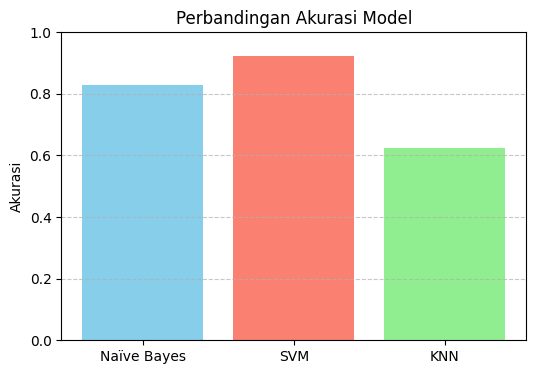

In [ ]:
# Visualisasi Perbandingan Akurasi
plt.figure(figsize=(6, 4))
plt.bar(['Naïve Bayes', 'SVM', 'KNN'], [accuracy_nb, accuracy_svm, accuracy_knn], color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Akurasi')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

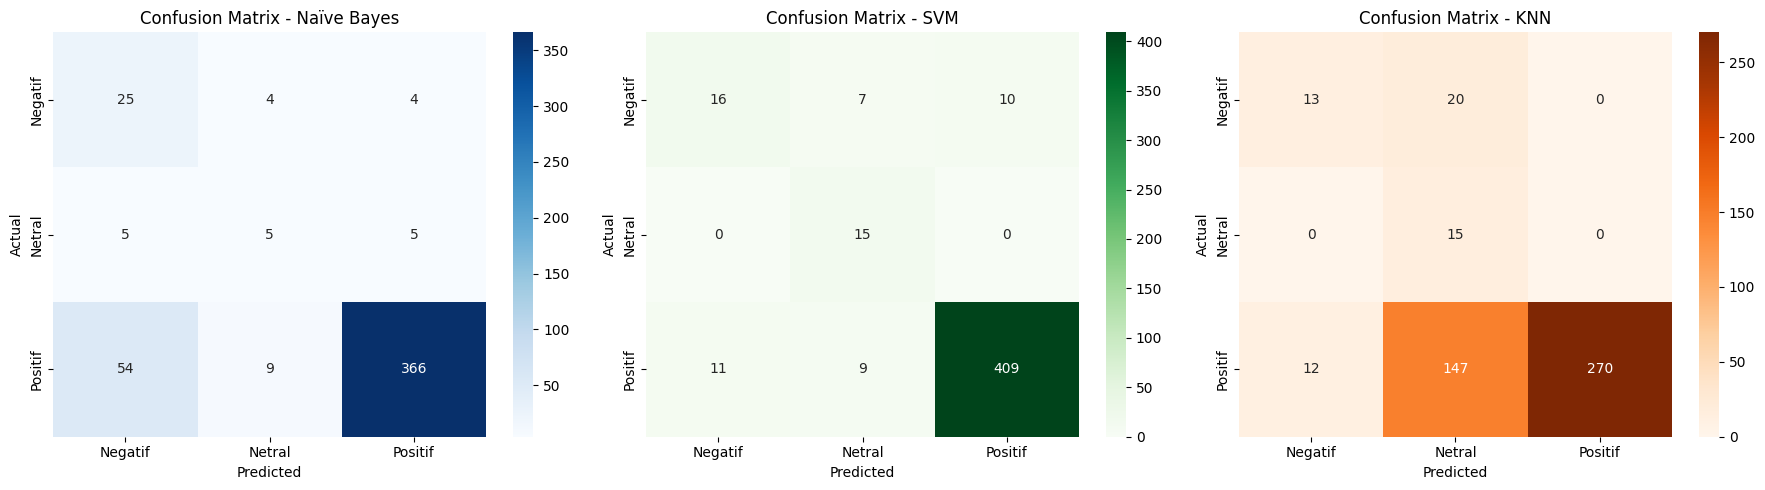

In [ ]:
# Confusion Matrix Heatmap
nb_cm = confusion_matrix(y_test, predictions_nb, labels=[-1, 0, 1])
svm_cm = confusion_matrix(y_test, predictions_svm, labels=[-1, 0, 1])
knn_cm = confusion_matrix(y_test, predictions_knn, labels=[-1, 0, 1])

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif", "Netral", "Positif"], yticklabels=["Negatif", "Netral", "Positif"], ax=ax[0])
ax[0].set_title("Confusion Matrix - Naïve Bayes")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Negatif", "Netral", "Positif"], yticklabels=["Negatif", "Netral", "Positif"], ax=ax[1])
ax[1].set_title("Confusion Matrix - SVM")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Oranges", xticklabels=["Negatif", "Netral", "Positif"], yticklabels=["Negatif", "Netral", "Positif"], ax=ax[2])
ax[2].set_title("Confusion Matrix - KNN")
ax[2].set_xlabel("Predicted")
ax[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()